<a href="https://colab.research.google.com/github/MananShukla7/Colab-Notebook/blob/main/03_Neural_Network_Classification_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. NN Classification with pytorch

Classification is a problem wgere something is one thing or another(there can be
multiple things as options!)

##1. Data (ml is nothing without data mate!!)

Make classification data and get it ready

In [2]:
import sklearn
import pandas as pd
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import make_circles

#Make 1000 samples
n_samples=1000

#Create circles
X,y=make_circles(n_samples,
                noise=0.03,random_state=42)

In [4]:
len(X),len(y)

(1000, 1000)

In [5]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [6]:
#Make DataFrame of circle data 
circles =pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


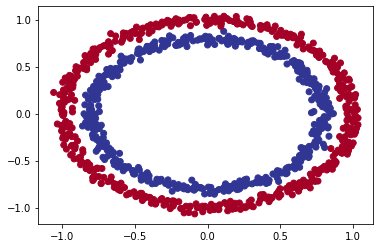

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
             y=X[:,1],
             c=y,
             cmap=plt.cm.RdYlBu);

Note: the data we are working with is also reffered sas toy dataset,a small data
enough to experiment and scalable enough to practice the fundamentals

### 1.1 Check input and output shapes


In [8]:
X.shape,y.shape

((1000, 2), (1000,))

In [9]:
#View the features of labels
X_sample=X[0]
y_sample=y[0]
print(f"Values of one samples of X:{X_sample} and same for y:{y_sample}")
print(f"Shape of one samples of X:{X_sample.shape} and same for y:{y_sample.shape}")

Values of one samples of X:[0.75424625 0.23148074] and same for y:1
Shape of one samples of X:(2,) and same for y:()


### 1.2 get data into tensors and create train and test split

In [10]:
#turn data into tensors
##Numpy has default dtype of float 64 but tensors have float32 and that may cause
##probs in the future so we use type(torch.float) for conversion
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

In [11]:
X[:5],y[:5],X.dtype,y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]),
 torch.float32,
 torch.float32)

In [12]:
#Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,
                                               train_size=0.8,
                                               random_state=42)

In [13]:
len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

##2. Building a model!

Lets build a model to classify blue and red dots

To do so we want to:
1. Setup device agnostic so it can run on accelerator if theres one
2. Construct a model(by subclassing nn.Module)
3. Define a loss function anf optimizer
4. Create train and test loop

In [14]:
#Device agnostic
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Now we've setup device agnostic code ,lets creatw model:

1. Subclass `nn.module`(almost all models are in this module)
2. Create 2 `nn.linear()` layers that are capable of handling the shapes of
our data
3. define a `forward()` method that outlines the forward pass of the model
4. Instantiate the model and send it to target `device`!!

In [15]:
#1. construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handling shapes of our data
    self.layer_1=nn.Linear(in_features=2,out_features=5)#takes in 2 features and upscale it to 5!
    self.layer_2=nn.Linear(in_features=5,out_features=1)#takes in 5 features and ops 1 features (same shape as y)
    # self.two_layers=nn.Sequential(
    # nn.Linear(in_features=2,out_features=5),
    # nn.Linear(in_features=5,out_features=1))


  #3. Define a forwaard method that outlines the f/w pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) #x -> l1 -> l2 -> o/p
    # return self.two_layers(x)
#4. Instantiate an instance of our model class and send it to the target device
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cpu')

In [17]:
#lets replicate the model above using nn.sequential
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    # nn.ReLU(),
    nn.ReLU(),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

In [18]:
with torch.inference_mode():
  untrained_preds=model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"First 10 preds:\n {torch.round(untrained_preds[:10])}")
  print(f"First 10 preds:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
First 10 preds:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [0.],
        [-0.]])
First 10 preds:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


###2.1 Setup loss fn and optimizer

which loss fn and opti should we use??
for ex
- regression we want MAE or MSE
- for classification we want BCE loss or CE loss

As a reminder the lossfn measures how wrong our models preds are!!

###what is a logits layer in deep learning:
* Its basically a layer that feeds in to softmax.the o/p of softmax layer is probabilities and
the input is logits

*  Logits are the values produced b/w -inf to +inf and they are converted into probabilities of 
0 to 1 by softmax layer

and for optimizers 2 common are sgd and adam!

In [19]:
#Setup the loss function
#Now loss_fn=nn.BCELoss() exists but it needs the inp data to go through the sigmoid activtn fn 
#prior to the input to BCELoss!
loss_fn=nn.BCEWithLogitsLoss()#withLogitsLoss-sigmoid fun built in(more stable than w/o logitloss)

optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [20]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.4603, -0.1139],
                      [-0.3825, -0.4400],
                      [-0.6958,  0.5800],
                      [-0.4543, -0.5800],
                      [-0.6076,  0.2165]])),
             ('0.bias', tensor([-0.3579,  0.0643, -0.6737, -0.2727, -0.4894])),
             ('2.weight',
              tensor([[-0.0189,  0.2831, -0.1136, -0.0700, -0.2464]])),
             ('2.bias', tensor([-0.0714]))])

In [21]:
#Calc the accuracy=out of 100 examples, what percent does our model gets right?

def accuracy(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

### 3. Training a model
To train our model we are going to need the training loop with following steps:

1. Forward pass
2. Calc the loss
3. Optimize Zero grad
4. Loss Backward(BackProp)
5. Optimizer step step step!!! 

### 3.1 Going from raw logits-> pred probabilities-> prediction labels
Our model o/ps are going to be raw **Logits** for us!
We can covert this **logits** into pred probabilities by passing them to some kind of 
activation fun(eg sigmoid for bianry classificstion and softmax for multiclass classification).

Then we can converet our model's prediction probabilities to prediction labels by either rounding them or taking the argmax()

In [22]:
#view the first 5 ops on test data
model_0.eval()
with torch.inference_mode():
  y_logits=model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0714],
        [-0.0714],
        [ 0.0460],
        [-0.0811],
        [-0.0042]])

In [23]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [24]:
#Use sigmoid activation fun on our logits to turn them into pred probabilities
y_pred_probs=torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4821],
        [0.4821],
        [0.5115],
        [0.4797],
        [0.4990]])

For out pred prob values we need to perform a range style rounding on them
`y_pred_probs`>=0.5, `y=1` (class 1)

else <0.5 then `y=0` (class 0)

In [25]:
y_pred=torch.round(y_pred_probs).squeeze()
y_pred

#in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5])).squeeze()
print(torch.eq(y_pred,y_pred_labels))

tensor([True, True, True, True, True])


In [26]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [27]:
from torch.autograd import backward

torch.cuda.manual_seed(42)
torch.manual_seed(42)

### 3.2 Building a training and testing loop
epochs=10000
train_l=[]
test_l=[]
#put data to target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)
###Training
for epoch in range(epochs):
  #Put in train mode
  model_0.train()
  
  #Forward pass
  # y_pred_new=model_0(X_train)

  y_logits=model_0(X_train).squeeze()
  y_pred_new=torch.round(torch.sigmoid(y_logits))

  #calc loss/accuracy
  # loss=loss_fn(torch.sigmoid(y_logits)) #nn>BCEloss w/o logits!
  train_loss=loss_fn(y_logits,y_train)#nn.BCEwithLogitsLoss expects the raw logits loss
  train_l.append(train_loss.cpu().detach().numpy())
  acc=accuracy(y_true=y_train,y_pred=y_pred_new)

  #zero grad
  optimizer.zero_grad()

  #back prop
  train_loss.backward()

  #step optimizer
  optimizer.step()

  #Test loop
  model_0.eval()
  with torch.inference_mode():
    #1. forward pass
    test_logits=model_0(X_test).squeeze()

    y_pred_test=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(y_pred_test,y_test)
    test_l.append(test_loss.cpu().detach().numpy())
    test_acc=accuracy(y_test,y_pred_test)
    if epoch%1000==0:
      print(f"Epoch:{epoch} | Train Loss:{train_loss:.5f} | Train acc:{acc:.2f}% | Test Loss:{test_loss:.5f} | Test acc:{test_acc:.2f}%")
  

Epoch:0 | Train Loss:0.69392 | Train acc:49.50% | Test Loss:0.70968 | Test acc:54.50%
Epoch:1000 | Train Loss:0.62579 | Train acc:73.75% | Test Loss:0.64170 | Test acc:70.50%
Epoch:2000 | Train Loss:0.44984 | Train acc:94.88% | Test Loss:0.52390 | Test acc:95.50%
Epoch:3000 | Train Loss:0.25928 | Train acc:99.62% | Test Loss:0.51320 | Test acc:98.00%
Epoch:4000 | Train Loss:0.17620 | Train acc:99.75% | Test Loss:0.51320 | Test acc:98.00%
Epoch:5000 | Train Loss:0.13391 | Train acc:99.88% | Test Loss:0.51320 | Test acc:98.00%
Epoch:6000 | Train Loss:0.10861 | Train acc:99.88% | Test Loss:0.51320 | Test acc:98.00%
Epoch:7000 | Train Loss:0.09159 | Train acc:99.88% | Test Loss:0.50700 | Test acc:99.00%
Epoch:8000 | Train Loss:0.07920 | Train acc:99.88% | Test Loss:0.50700 | Test acc:99.00%
Epoch:9000 | Train Loss:0.06977 | Train acc:99.88% | Test Loss:0.50510 | Test acc:99.50%


In [28]:
#analysis
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

## 4. Make predictions and evaluate the model

From looking at the metrics it looks like the model isnt learning anything
So to inspect we make preds and **visualize visualize visualize**

To do so,we are going to import fun `plot_decision_boundary()`

In [29]:
import requests
from pathlib import Path
#Download helper funs from learn_pytorch repo(if its not already dwnlded)

if Path("helper_fn.py").is_file():
  print("Already imported")
else:
  print("Downloading helper_funs")
  request=requests.get("https://github.com/MananShukla7/Colab-Notebook/raw/main/helper_functions.py")
  with open("helper_fn.py","wb") as f:
    f.write(request.content)
from helper_fn import plot_decision_boundary, lossfn_curve, plot_predictions

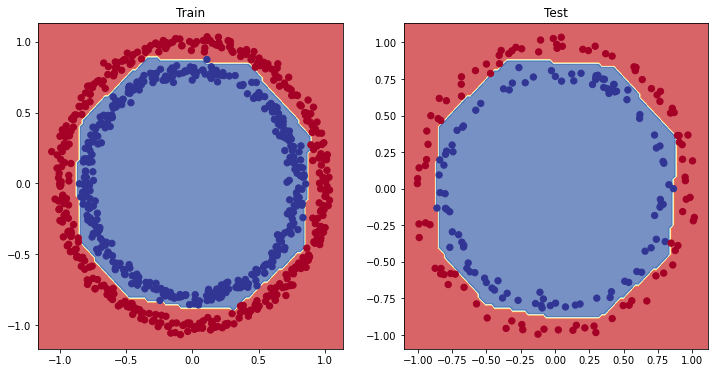

In [30]:
#PLOT THE DECISION BOUNDARY
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

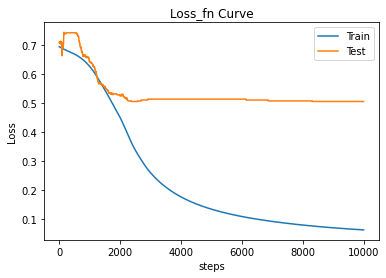

In [31]:
lossfn_curve(train_l,epochs)
lossfn_curve(test_l,epochs)
plt.legend(["Train","Test"])
plt.show()

In [32]:
td="""
Make my own decision boundary fun(if poss)
make helper fun(must)
add it on my github(must)
understant the funs inside(some of them)
"""

In [33]:
print(td)


Make my own decision boundary fun(if poss)
make helper fun(must)
add it on my github(must)
understant the funs inside(some of them)



### 5. Improving the model(From a model's perspective)

- Add more layers- give model more chances to learn about the patterns in data
- Add more hidden units-add more neurons to get more features as they increase the Parameters. 
* **This 2 changes could result in overfitting**

- Fit for longer
-Changing activation funs
-change the learning rate
-change the loss funs

These options are all from a models perspective because they dealt directly with the model, rather than the data

And because these opts are all values we
 can change,there are called **HyperParameters**.

####4.1. ReCreating the model (V1)


4.1.1. Change the hidden units

In [34]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    # z=self.layer_1(x)
    # z=self.layer_2(z)
    # z=self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))#This way of writitng operartions results in speedups!

model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
#Loss_fn
loss_fn=nn.BCEWithLogitsLoss()#withLogitsLoss-sigmoid fun built in(more stable than w/o logitloss)
#optimizer
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [36]:
torch.cuda.manual_seed(42)
torch.manual_seed(42)

### 3.2 Building a training and testing loop
epochs=1000
train_l=[]
test_l=[]
#put data to target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)
###Training
for epoch in range(epochs):
  #Put in train mode
  model_1.train()
  
  #Forward pass
  # y_pred_new=model_0(X_train)

  y_logits=model_1(X_train).squeeze()
  y_pred_new=torch.round(torch.sigmoid(y_logits))

  #calc loss/accuracy
  # loss=loss_fn(torch.sigmoid(y_logits)) #nn>BCEloss w/o logits!
  train_loss=loss_fn(y_logits,y_train)#nn.BCEwithLogitsLoss expects the raw logits loss
  train_l.append(train_loss.cpu().detach().numpy())
  acc=accuracy(y_true=y_train,y_pred=y_pred_new)

  #zero grad
  optimizer.zero_grad()

  #back prop
  train_loss.backward()

  #step optimizer
  optimizer.step()

  #Test loop
  model_0.eval()
  with torch.inference_mode():
    #1. forward pass
    test_logits=model_1(X_test).squeeze()

    y_pred_test=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(y_pred_test,y_test)
    test_l.append(test_loss.cpu().detach().numpy())
    test_acc=accuracy(y_test,y_pred_test)
    if epoch%100==0:
      print(f"Epoch:{epoch} | Train Loss:{train_loss:.5f} | Train acc:{acc:.2f}% | Test Loss:{test_loss:.5f} | Test acc:{test_acc:.2f}%")
  

Epoch:0 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:100 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:200 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:300 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:400 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:500 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:600 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:700 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:800 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%
Epoch:900 | Train Loss:0.69396 | Train acc:50.88% | Test Loss:0.75541 | Test acc:51.00%


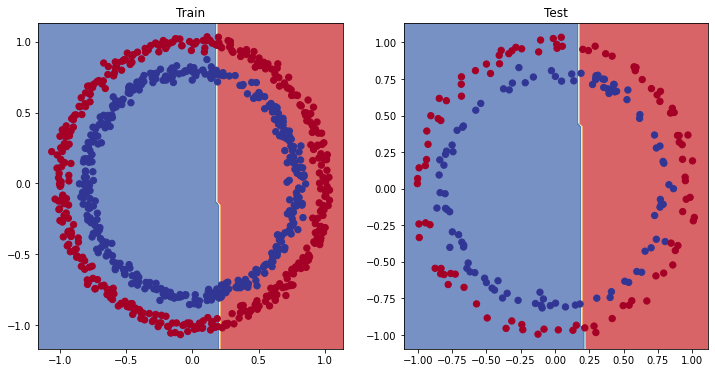

In [37]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

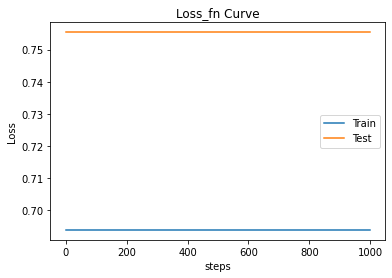

In [38]:
lossfn_curve(train_l,epochs)
lossfn_curve(test_l,epochs)
plt.legend(["Train","Test"])
plt.show()

Change in the **hidden units** and **increase in the no of epochs** brought no change model is still predicting randomly!

4.1.1.1.  prepare a model to see if our model can fit a straight line
### one way to troubleshoot is to see a larger problem is to test out a smaller problem

In [39]:
#Create a straight line
weight=0.7
bias=0.3

#Create range values
start=0
end=1
step=0.01
X_regression=torch.arange(start,end,step).reshape(-1,1)

y_regression=weight*X_regression+bias

X_regression[:5],y_regression[:5]


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [40]:
#train test split
%%capture
train_len=int(0.8*len(X_regression))
X_train_regression,y_train_regression=X_regression[:train_len],y_regression[:train_len]
X_test_regression,y_test_regression=X_regression[train_len:],y_regression[train_len:]
X_train_regression.shape,y_train_regression.shape,X_test_regression.shape,y_test_regression.shape
X_train_regression.to(device),y_train_regression.to(device),X_test_regression.to(device),y_test_regression.to(device)


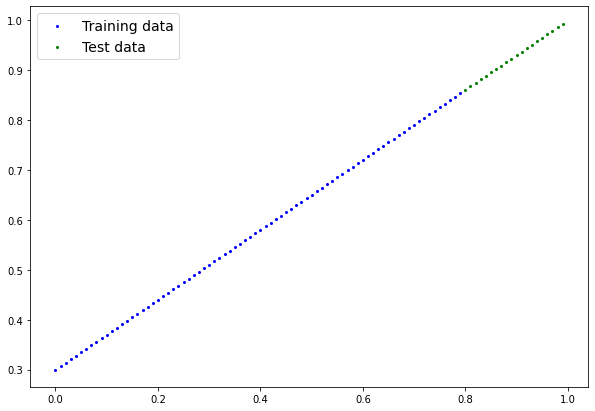

In [41]:
plot_predictions(X_train_regression,
                 y_train_regression,
                 X_test_regression,
                 y_test_regression)

4.1.2. Adjusting `model_1` to fit a regression model
Use same archi as model1


In [42]:
model_2=nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1)
).to(device)

model_2.to(device)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
##loss_fn and opti

lfn=nn.L1Loss()
opti=torch.optim.SGD(params=model_2.parameters(),lr=0.01)

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=500

X_train_regression,y_train_regression,X_test_regression,y_test_regression=X_train_regression.to(device),y_train_regression.to(device),X_test_regression.to(device),y_test_regression.to(device)

for epoch in range(epochs):
  y_pred=model_2(X_train_regression)
  loss=lfn(y_pred,y_train_regression)
  opti.zero_grad()
  loss.backward()
  opti.step()

  model_2.eval()
  with torch.inference_mode():
    test_pred=model_2(X_test_regression)
    test_loss=lfn(test_pred,y_test_regression)

    if epoch%10==0:
      print(f"Epoch:{epoch} | Train Loss:{loss:.5f} | Test Loss:{test_loss:.5f}")
  


Epoch:0 | Train Loss:0.75986 | Test Loss:0.91103
Epoch:10 | Train Loss:0.40240 | Test Loss:0.50474
Epoch:20 | Train Loss:0.06007 | Test Loss:0.10151
Epoch:30 | Train Loss:0.01559 | Test Loss:0.03231
Epoch:40 | Train Loss:0.03092 | Test Loss:0.00111
Epoch:50 | Train Loss:0.03196 | Test Loss:0.00108
Epoch:60 | Train Loss:0.03192 | Test Loss:0.00170
Epoch:70 | Train Loss:0.03081 | Test Loss:0.00097
Epoch:80 | Train Loss:0.03077 | Test Loss:0.00150
Epoch:90 | Train Loss:0.02967 | Test Loss:0.00092
Epoch:100 | Train Loss:0.02858 | Test Loss:0.00081
Epoch:110 | Train Loss:0.02962 | Test Loss:0.00197
Epoch:120 | Train Loss:0.02748 | Test Loss:0.00091
Epoch:130 | Train Loss:0.02852 | Test Loss:0.00181
Epoch:140 | Train Loss:0.02850 | Test Loss:0.00246
Epoch:150 | Train Loss:0.02744 | Test Loss:0.00169
Epoch:160 | Train Loss:0.02638 | Test Loss:0.00123
Epoch:170 | Train Loss:0.02637 | Test Loss:0.00162
Epoch:180 | Train Loss:0.02532 | Test Loss:0.00125
Epoch:190 | Train Loss:0.02636 | Test Loss

In [45]:
with torch.inference_mode():
    pred=model_2(X_test_regression)
    

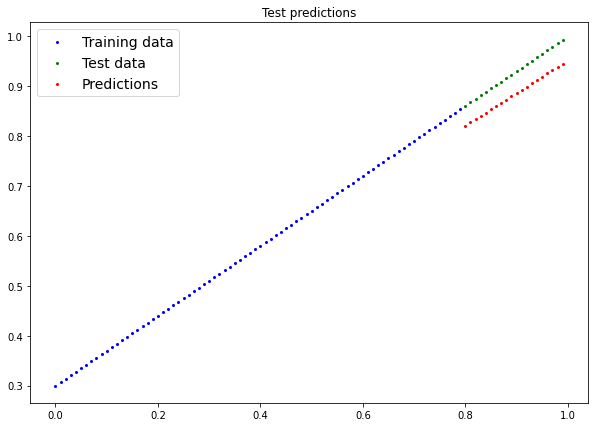

In [46]:
plot_predictions(X_train_regression.cpu(),
                 y_train_regression.cpu(),
                 X_test_regression.cpu(),
                 y_test_regression.cpu(),
                 p_test=pred.cpu().detach().numpy())

## 5. The missing piece:non-linearity

"What patterns could you draw if you were given infinite no of straight and non-straight lines"

or in ml terms,an infinite of linear and non linear functions

### 5.1 Recreating non-linear data(red blue circles)


In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import pandas as pd
n_samples=1000

X,y=make_circles(n_samples,noise=0.03,random_state=42)
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]), array([1, 1, 1, 1, 0]))

In [48]:
def plot_classfication_data_V0(X):
  plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu);

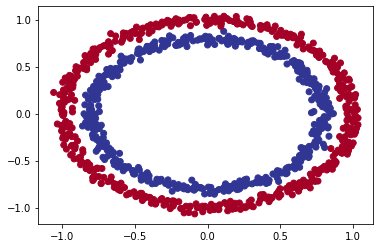

In [49]:
plot_classfication_data_V0(X)

In [50]:
from pathlib import Path
import requests
if Path("helper_fn.py").is_file():
  print("Already imported")
else:
  request=requests.get("https://github.com/MananShukla7/Colab-Notebook/raw/main/helper_functions.py")
  with open("helper_fn.py","wb") as f:
    f.write(request.content)
from helper_fn import plot_decision_boundary, lossfn_curve, plot_predictions, plot_classfication_data_V1


Already imported


In [51]:
from sklearn.model_selection import train_test_split

# X=torch.from_numpy(X).type(torch.float)

# y=torch.from_numpy(y).type(torch.float)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_test.shape,X_train.shape,y_test.shape,y_train.shape
X_test,X_train,y_test,y_train=torch.from_numpy(X_test).type(torch.float),torch.from_numpy(X_train).type(torch.float),torch.from_numpy(y_test).type(torch.float),torch.from_numpy(y_train).type(torch.float)

### 5.2 Building a model from non-linearity

In [52]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU()
    
  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()
model_3.to(device)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [53]:
##loss_fn and opti
loss_fn=nn.BCEWithLogitsLoss()

opti=torch.optim.Adam(params=model_3.parameters(),lr=0.01)

In [54]:
y_train.shape


torch.Size([800])

In [55]:
##train and test loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs=1000
##to device
train_l=[]
test_l=[]
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  train_logits=model_3(X_train).squeeze()
  y_pred_train=torch.round(torch.sigmoid(train_logits))

  train_loss=loss_fn(train_logits,y_train)
  train_l.append(train_loss.cpu().detach().numpy())

  opti.zero_grad()

  train_loss.backward()

  opti.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    y_pred_test=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_l.append(test_loss.cpu().detach().numpy())

    if epoch%100==0:
      print(f"Epoch:{epoch} | Train Loss:{train_loss:.5f} | Test Loss:{test_loss:.5f}")
  
    

Epoch:0 | Train Loss:0.69295 | Test Loss:0.69203
Epoch:100 | Train Loss:0.17334 | Test Loss:0.20684
Epoch:200 | Train Loss:0.01503 | Test Loss:0.02743
Epoch:300 | Train Loss:0.00581 | Test Loss:0.01481
Epoch:400 | Train Loss:0.00317 | Test Loss:0.01065
Epoch:500 | Train Loss:0.00200 | Test Loss:0.00874
Epoch:600 | Train Loss:0.00138 | Test Loss:0.00754
Epoch:700 | Train Loss:0.00101 | Test Loss:0.00677
Epoch:800 | Train Loss:0.00076 | Test Loss:0.00622
Epoch:900 | Train Loss:0.00060 | Test Loss:0.00579


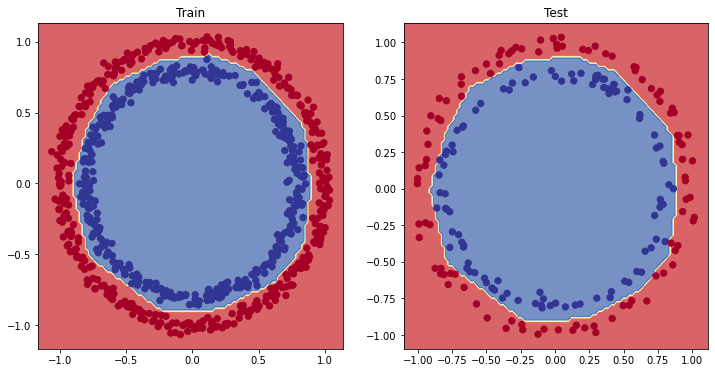

In [56]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model_3,X_train,y_train);
plt.title("Train");
plt.subplot(1,2,2)
plot_decision_boundary(model_3,X_test,y_test);
plt.title("Test");

### 7. Replicating the non-linear activation functions

Neural nn ,rather than telling the model what to learn, we give it tools to figure out the patterns in the data
by itself

This functions are **Linear and non-linear activation funs!!**

In [57]:
#Create a tensor
A=torch.arange(-10,10,1,dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

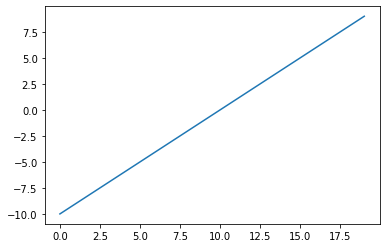

In [58]:
plt.plot(A)
def relu(x):
  return torch.max(torch.tensor(0),x)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

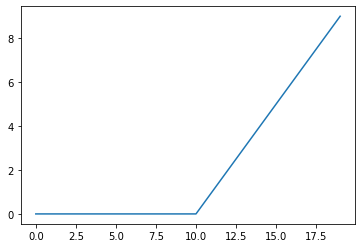

In [59]:
plt.plot(relu(A));
relu(A)

In [60]:
def sigmoid(x):
  return 1/(1+torch.exp(-(x)))

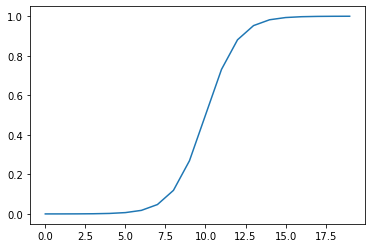

In [61]:
plt.plot(sigmoid(A));

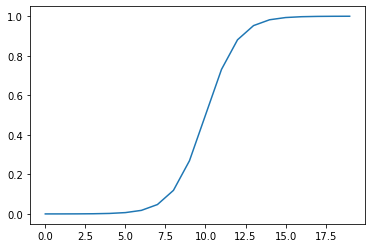

In [62]:
plt.plot(torch.sigmoid(A));

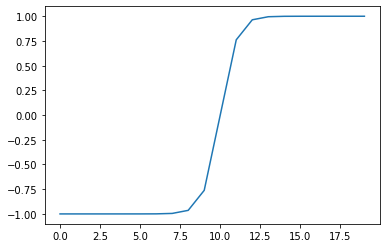

In [63]:
plt.plot(torch.tanh(A))

In [64]:
# from sklearn.datasets import make_blobs, make_biclusters
# n_samples=1000
# X,y=make_blobs(n_samples,centers=3,random_state=42)
# X[:5,0],X[:5,1]

## 7.Putting it all together with a multi-class classification

Binary classification = cat or dog, email spam or not spam,etc.

Multi class classification=cat,dog or hen, types of food,etc.

In [65]:
#import dependencies
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split 

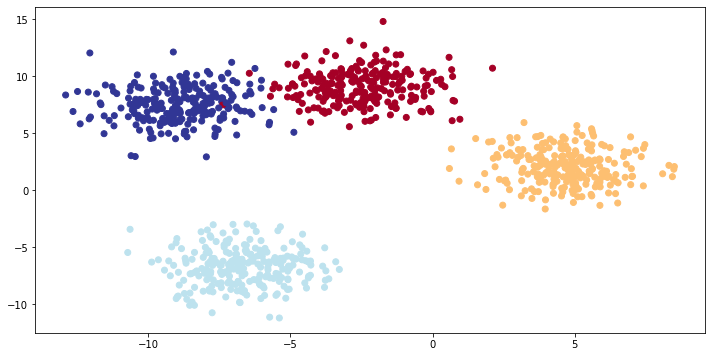

In [66]:
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED=42
#1. Create nulti-class data
X_blob,y_blob=make_blobs(n_samples,
                         n_features=NUM_FEATURES,
                         centers=NUM_CLASSES,
                         cluster_std=1.5,
                         random_state=RANDOM_SEED,
                         )

X_blob[:5],y_blob[:5]

#2. turn into tensor
X_blob=torch.from_numpy(X_blob).type(torch.float)
y_blob=torch.from_numpy(y_blob).type(torch.float)

# 3. train test split
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blob,y_blob,test_size=0.2,random_state=RANDOM_SEED)

#4.plot the data

plt.figure(figsize=(12,6))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

###7.2, Building a multiclassification model in pytorch

In [67]:
#create device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [93]:
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    """
    Initializes a multi-class classification model.

    Args:
      input_features(int):Number of input features to model
      output_features(int):Number of output features to model
      hidden_units=No of hidden units b/w each layer(dafault=8)

    Returns:

    Example:
    """

    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

model_4=BlobModel(input_features=2,
                  output_features=4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [94]:
X_blob_train.shape,y_blob_train[:5]

(torch.Size([800, 2]), tensor([1., 0., 2., 2., 0.]))

In [95]:
y_blob_train.unique()

tensor([0., 1., 2., 3.])

###7.3 Building a model

####loss_fn and opti selection

In [96]:
#Loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
#Adam opti
opti=torch.optim.Adam(params=model_4.parameters(),lr=0.001)


####Getting predictions from our model

In [97]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4.eval()
with torch.inference_mode():
  y_pred=model_4(X_blob_test.to(device))
y_pred[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

In [99]:
logits=torch.softmax(y_pred,dim=1)
true_ans=torch.argmax(logits,dim=1)


In [100]:
y_blob_test.type(torch.LongTensor)

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

###Create a training and testing loop for multiclass pytorch model

In [101]:
#Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs 
epochs=100

X_blob_train,y_blob_train=X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test=X_blob_test.to(device),y_blob_test.to(device)

#loop through the data
for epoch in range(epochs):
  model_4.train()
  y_logits=model_4=(X_blob_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1).type(torch.LongTensor)

  loss=loss_fn(y_logits,y_blob_train)
  train_acc=accuracy(y_true=y_blob_train,
                     y_pred=y_pred)
  opti.zero_grad()

  loss.backward()

  opti.step()

  model_4.eval()
  with torch.inference_mode():
    test_logits=model_4(X_blob_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    train_loss=loss_fn(test_logits,y_blob_test)
    test_acc=accuracy(y_true=y_blob_test,
                      y_pred=test_pred)
    
    if epoch%10==0:
      print(f"Epoch: {epoch} | train_loss: {loss:.4f} | train_acc: {train_acc:.2f} | test_loss: {test_acc:.4f} |  test_acc: {test_acc:.2f}")


RuntimeError: ignored